# TechLab Big Data - Direct Marketing

## 1. Analisi descrittiva e esplorativa

### Import delle librerie

Come prima cosa importiamo le librerie e i moduli che saranno necessarie per l'implementazione del caso di studio. 

Le librerie di interesse sono: 

- Pandas: per la manipolazione di dati in formato sequenziale o tabellare;
- Matplot e Seaborn: per la generazione di grafici; 
- Scikit-learn: per i modelli di Machine Learning.

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from inspect import signature
%matplotlib inline

from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import KFold
from sklearn                   import metrics
from sklearn.ensemble          import GradientBoostingClassifier
from sklearn.svm               import SVC
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.metrics           import classification_report, precision_score, recall_score, f1_score
from sklearn                   import tree
from inspect                   import signature

### Informazioni del Dataset

Importiamo il dataset e mostriamo le prime osservazioni per capire com'è strutturato.

In [2]:
bank = pd.read_csv('Data/campagna-target.csv', sep = ';')
bank.head()

,eta,professione,stato_civile,istruzione,default,prestito_casa,prestito_personale,mese,giorno_settimana,campagne,giorni_p,precedente,outcome_p,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Il dataset in questione è costituito da 39468 osservazioni, per ognuna delle quali sono stati registrati i valori di 19 variabili. 

In [3]:
print("Numero righe:    ", bank.shape[0])
print("Numero colonne:   ", bank.shape[1])

Numero righe:     39468
Numero colonne:    19


Le 18 variabili indipendenti riguardano informazioni relative al cliente, alla campagna pubblicitaria e alcuni indici socio-economici. 
<br>
Nel dettaglio: 

- Età: età del cliente;
- Professione: tipo di lavoro del cliente;
- Stato_civile: stato civile del cliente;
- Istruzione: livello di educazione del cliente;
- Default: se il cliente ha o non ha crediti in default;
- Prestito_casa: se il cliente ha o non ha un mutuo sulla casa in essere;
- Prestito_personale: se il cliente ha o non ha un mutuo personale;
- Mese: mese in cui ha avuto luogo la campagna pubblicitaria;
- Giorno_settimana: giorno della settimana in cui ha avuto luogo la campagna pubblicitaria;
- Campagne: numero di volte in cui il cliente è stato esposto alla campagna pubblicitaria in corso;
- Giorni_p: numero di giorni passati dall'ultima volta in cui il cliente è stato esposto ad una campagna pubblicitaria precedente;
- Precedente: numero di volte in cui il cliente è stato esposto a campagne pubblicitarie precedenti;
- Outcome_p: risultato della campagna precedente; 
- Emp.var.rate: tasso di variazione dell'occupazione;
- Cons.price.idx: indice dei prezzi al consumo;
- Cons.conf.idx: indice di fiducia dei consumatori;
- Euribor3m: tasso euribor a 3 mesi;
- Nr.employed: numero di dipendenti (migliaia). 

La variabile target y assume valori binari Sì/No se il cliente ha sottoscritto o meno il prodotto o servizio presente nella campagna pubblicitaria corrente. 

In [4]:
list(bank.columns)

['eta',
 'professione',
 'stato_civile',
 'istruzione',
 'default',
 'prestito_casa',
 'prestito_personale',
 'mese',
 'giorno_settimana',
 'campagne',
 'giorni_p',
 'precedente',
 'outcome_p',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

Controlliamo se nel dataset sono presenti osservazioni con valori mancanti per qualche variabile. <br> In questo caso, non risultano esserci missing values in nessuna delle colonne. 

In [5]:
bank.isnull().sum()

eta                   0
professione           0
stato_civile          0
istruzione            0
default               0
prestito_casa         0
prestito_personale    0
mese                  0
giorno_settimana      0
campagne              0
giorni_p              0
precedente            0
outcome_p             0
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
nr.employed           0
y                     0
dtype: int64

In seguito, bisogna controllare il tipo e il formato in cui i dati delle varie colonne sono stati salvati. <br> Troviamo 3 diversi tipi di formato dei dati: 
- int64: numeri interi;
- float64: numeri decimali; 
- object: stringhe di caratteri. 

In [6]:
bank.dtypes

eta                     int64
professione            object
stato_civile           object
istruzione             object
default                object
prestito_casa          object
prestito_personale     object
mese                   object
giorno_settimana       object
campagne                int64
giorni_p                int64
precedente              int64
outcome_p              object
emp.var.rate          float64
cons.price.idx        float64
cons.conf.idx         float64
euribor3m             float64
nr.employed           float64
y                      object
dtype: object

### Studio della variabile categorica 'Professione'

A titolo esemplificativo, scegliamo la variabile 'Professione' per studiarne alcune caratteristiche e metodologie che possiamo utilizzare per effettuare le analisi successive e che potranno essere applicate in maniera analoga anche alle altre variabili dello stesso tipo.
<br> Si può notare come la varibile 'Professione' di tipo stringa in realtà assuma solo un numero finito di valori, detti livelli. In questo caso si parla di variabile categorica a 11 livelli. 

In [7]:
print('Variabile Professione')
print('Numero livelli: ',len(bank['professione'].unique()))
print(bank['professione'].unique())

Variabile Professione
Numero livelli:  11
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'management'
 'unemployed' 'self-employed' 'unknown' 'entrepreneur' 'student']


Nel grafico seguente, si può notare come le varie categorie del tipo di impiego siano ditribuite all'interno dell'intero dataset. 

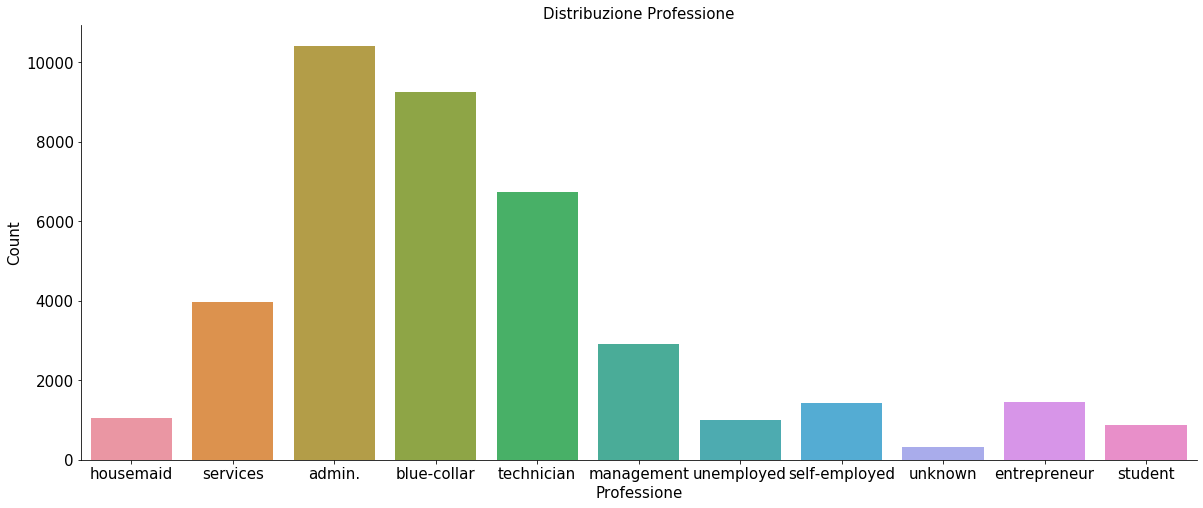

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'professione', data = bank)
ax.set_xlabel('Professione', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Distribuzione Professione', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

### Studio della variabile numerica 'Età' 

La variabile 'Età', contrariamente a quanto visto in precedenza per la variabile 'Professione', è di tipo numerico. Infatti la variabile può assumere qualsiasi valore reale positivo e possiamo quindi srtudiare la loro distribuzione e relativo box-plot.
<br> 

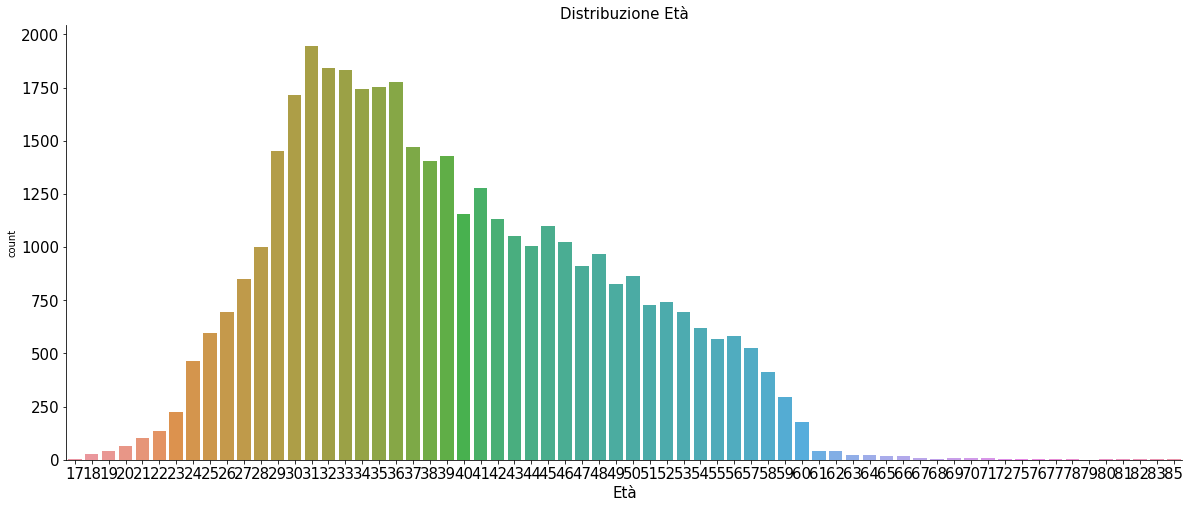

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'eta', data = bank)
ax.set_xlabel('Età', fontsize=15)
ax.set_title('Distribuzione Età', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

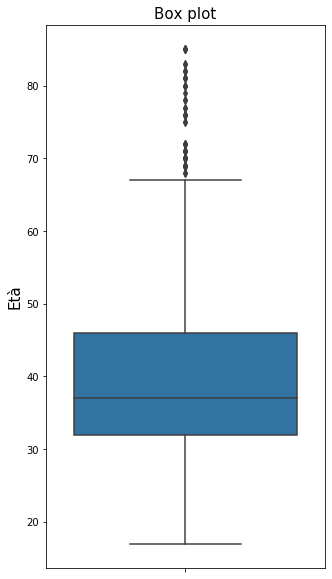

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(5,10)
sns.boxplot(y=bank['eta'])
ax.set_ylabel('Età', fontsize=15)
ax.set_title('Box plot',fontsize=15)
plt.show()